<a href="https://colab.research.google.com/github/sobir-git/some-credit-scoring-tasks/blob/main/task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq seaborn catboost

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -j -o /content/drive/MyDrive/tmp/task_ml.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/tmp/task_ml.zip
  inflating: ._task                  
  inflating: credit_test.csv         
  inflating: ._credit_test.csv       
  inflating: merchants_train.csv     
  inflating: ._merchants_train.csv   
  inflating: .DS_Store               
  inflating: ._.DS_Store             
  inflating: task_description.md     
  inflating: ._task_description.md   
  inflating: credit_train.csv        
  inflating: ._credit_train.csv      
  inflating: merchants_test.csv      
  inflating: ._merchants_test.csv    
  inflating: transactions.csv        
  inflating: ._transactions.csv      


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

transactions = pd.read_csv("transactions.csv", sep=',')
merchant_train = pd.read_csv("merchants_train.csv", sep=';')
merchant_test = pd.read_csv("merchants_test.csv", sep=';')

# convert columns real_transaction_dttm and record_date to datetime (times) objects
transactions['real_transaction_dttm'] = pd.to_datetime(transactions['real_transaction_dttm'], format='%H:%M:%S')
transactions['record_date'] = pd.to_datetime(transactions['record_date'], format='%H:%M:%S')

# drop transactions without location info
transactions = transactions[(transactions['latitude'] != 0) | (transactions['longitude'] != 0)]


In [4]:
# Check the first few rows of each dataset
print("transactions:", transactions.head())
print("merchant_train:", merchant_train.head())
print("merchant_test:", merchant_test.head())
print()

# Check the shape of each dataset
print("Data shape:")
print(transactions.shape)
print(merchant_train.shape)
print(merchant_test.shape)
print()

# Check for missing values
print("Missing value counts:")
print(transactions.isnull().sum())
print(merchant_train.isnull().sum())
print(merchant_test.isnull().sum())
print()

# Check the data types of each dataset
print("Data types:")
print(transactions.dtypes)
print(merchant_train.dtypes)
print(merchant_test.dtypes)

# Number of merchants in each dataset
print("Number of merchants in trainset:", merchant_train.merchant_id.nunique())
print("Number of merchants in testset:", merchant_test.merchant_id.nunique())
print("Number of merchants in testset that are not in trainset:", len(set(merchant_test.merchant_id) - set(merchant_train.merchant_id)))
print("Number of merchants in trainset that are not in testset:", len(set(merchant_train.merchant_id) - set(merchant_test.merchant_id)))



transactions:    merchant_id   latitude  longitude real_transaction_dttm         record_date
1          178  55.055996  82.912991   1900-01-01 17:49:50 1900-01-01 17:54:24
3          178  55.056034  82.912734   1900-01-01 17:49:50 1900-01-01 17:43:01
4          178  55.056034  82.912734   1900-01-01 17:49:50 1900-01-01 17:45:17
7          178  55.055996  82.912991   1900-01-01 17:49:50 1900-01-01 17:51:34
8          267  55.741642  37.502628   1900-01-01 15:34:28 1900-01-01 15:32:51
merchant_train:    merchant_id   latitude  longitude
0          178  55.055553  82.911833
1          267  55.726877  37.579645
2          357  54.706402  20.471420
3          505  64.553811  40.551964
4          532  55.768355  49.217176
merchant_test:    merchant_id  latitude  longitude
0          361       NaN        NaN
1          428       NaN        NaN
2          490       NaN        NaN
3         1175       NaN        NaN
4         1239       NaN        NaN

Data shape:
(224335, 5)
(6482, 3)
(3524, 3

Number of transactions: 224335


<Axes: title={'center': 'Number of transactions by merchants'}>

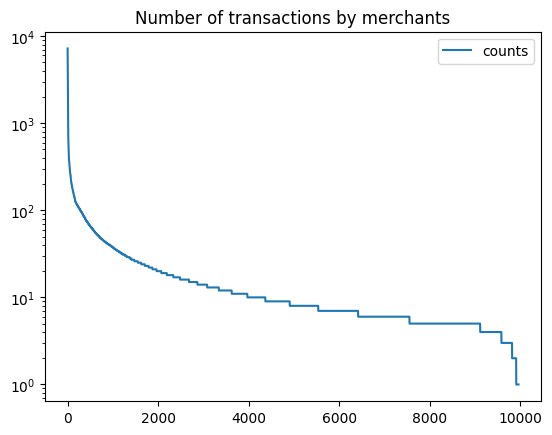

In [5]:
# Analyse transactions dataset
print("Number of transactions:", transactions.shape[0])
transactions_by_merchant = transactions.groupby("merchant_id").size().reset_index(name="counts")

# Visualize distribution of transactions by merchant, sorted by transaction counts
transactions_by_merchant.sort_values(by="counts", ascending=False).reset_index(drop=True).plot(logy=True, y="counts", kind="line", title="Number of transactions by merchants")


In [6]:
# Merge transactions with merchant_train
train_data = transactions.merge(merchant_train, on="merchant_id", suffixes=("_trans", "_merch"))

# Merge transactions with merchant_test
test_data = transactions.merge(merchant_test, on="merchant_id", suffixes=("_trans", "_merch"))

train_data


,merchant_id,latitude_trans,longitude_trans,real_transaction_dttm,record_date,latitude_merch,longitude_merch
0,178,55.055996,82.912991,1900-01-01 17:49:50,1900-01-01 17:54:24,55.055553,82.911833
1,178,55.056034,82.912734,1900-01-01 17:49:50,1900-01-01 17:43:01,55.055553,82.911833
2,178,55.056034,82.912734,1900-01-01 17:49:50,1900-01-01 17:45:17,55.055553,82.911833
3,178,55.055996,82.912991,1900-01-01 17:49:50,1900-01-01 17:51:34,55.055553,82.911833
4,267,55.741642,37.502628,1900-01-01 15:34:28,1900-01-01 15:32:51,55.726877,37.579645
...,...,...,...,...,...,...,...
150012,1869302,55.729407,37.617222,1900-01-01 18:22:43,1900-01-01 18:23:25,55.633221,37.624247
150013,1869302,55.882924,37.423825,1900-01-01 11:05:19,1900-01-01 11:04:38,55.633221,37.624247
150014,1869302,55.636120,37.621158,1900-01-01 14:21:16,1900-01-01 14:30:49,55.633221,37.624247
150015,1869302,55.882924,37.423825,1900-01-01 11:05:19,1900-01-01 11:04:20,55.633221,37.624247


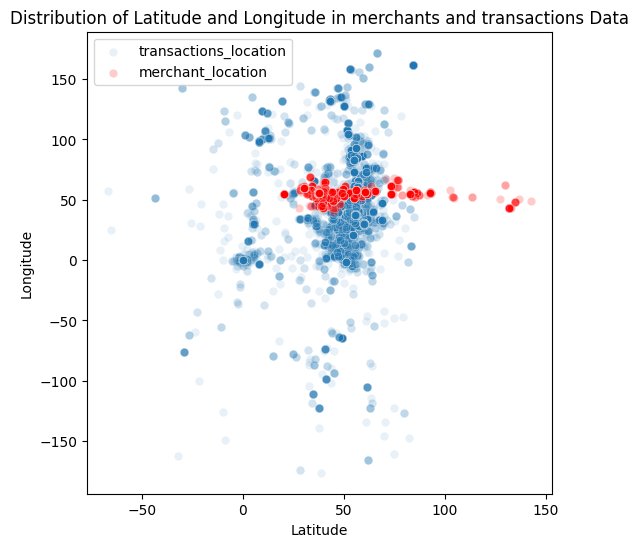

In [7]:
# Distribution of latitude and longitude in the transaction data
plt.figure(figsize=(6,6))
sns.scatterplot(x="latitude_trans", y="longitude_trans", data=train_data, alpha=0.1, label="transactions_location")
sns.scatterplot(x="longitude", y="latitude", data=merchant_train, alpha=0.2, color="red", label='merchant_location')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Distribution of Latitude and Longitude in merchants and transactions Data")
plt.show()

# Plot merchant locations as heatmap on the map
import folium
from folium.plugins import HeatMap
moscow_location = [55.7558, 37.6173]
m = folium.Map(location=moscow_location, zoom_start=2)
data = merchant_train[['latitude', 'longitude']]
HeatMap(data).add_to(m)
m


In [8]:
import folium
import random
selected_merchants = random.sample(train_data['merchant_id'].unique().tolist(), 10)

def visualize_transactions_on_map(data):
    # Initialize the map
    row = data.iloc[0]
    merch_location=[row['latitude_merch'], row['longitude_merch']]
    transaction_map = folium.Map(location=merch_location, zoom_start=2)

    # Add merchant location to the map
    popup=f"Merchant: {row['merchant_id']} <br> Merchant Location"
    folium.Marker(location=merch_location, popup=popup, icon=folium.Icon(color='red', icon='star')).add_to(transaction_map)

    # Add transaction locations to the map
    for index, row in data.iterrows():
        popup=f"Merchant: {row['merchant_id']} <br>Real Date: {row['real_transaction_dttm']} <br>Record Date: {row['record_date']}"
        folium.Marker(location=[row['latitude_trans'], row['longitude_trans']], popup=popup).add_to(transaction_map)

    return transaction_map

for merchant in selected_merchants[:1]:
    merchant_data = train_data[train_data['merchant_id'] == merchant] # .sort_values(by='transaction_date')  # Replace 'transaction_date' with the appropriate column name
    transaction_map = visualize_transactions_on_map(merchant_data)
    display(transaction_map)


# Preprocess data

In [9]:
from sklearn.preprocessing import StandardScaler


# create a clone of training data
df = train_data.copy()

# convert times to normalized numeric values in range [0,1)
df['real_transaction_dttm'] = df['real_transaction_dttm'].dt.hour / 24 + df['real_transaction_dttm'].dt.minute / (24 * 60) + df['real_transaction_dttm'].dt.second / (24 * 60 * 60)
df['record_date'] = df['record_date'].dt.hour / 24 + df['record_date'].dt.minute / (24 * 60) + df['record_date'].dt.second / (24 * 60 * 60)

df['time_diff'] = df['real_transaction_dttm'] - df['record_date']

groups = df.groupby('merchant_id')
df = pd.concat([
    groups['latitude_merch'].first(),
    groups['longitude_merch'].first(),
    groups.size().rename('transaction_count'),
    groups['time_diff'].agg(['min', 'max', 'mean', 'std', 'median']).add_suffix('_time_diff'),
    groups['record_date'].agg(['min', 'max', 'mean', 'std', 'median']).add_suffix('_record_date'),
    groups['real_transaction_dttm'].agg(['min', 'max', 'mean', 'std', 'median']).add_suffix('_real_transaction_dttm'),
    groups['latitude_trans'].agg(['min', 'max', 'mean', 'std', 'median']).add_suffix('_latitude'),
    groups['longitude_trans'].agg(['min', 'max', 'mean', 'std', 'median']).add_suffix('_longitude'),
    groups['real_transaction_dttm'].apply(lambda x: x.max() - x.min()).rename('time_span'),
], axis=1).reset_index()

# fill missing values with 0
df = df.fillna(0)

df_columns = df.columns
print(df_columns)

# Create scaler to normalize data
feature_columns = [col for col in df.columns if col not in ['merchant_id', 'latitude_merch', 'longitude_merch']]
target_columns = ['latitude_merch', 'longitude_merch']

print("Features info:")
df[feature_columns].info()

feature_scaler = StandardScaler()
target_scaler = StandardScaler(with_mean=False, with_std=False)
X = feature_scaler.fit_transform(df[feature_columns])
y = target_scaler.fit_transform(df[target_columns])

print('X.shape:', X.shape)
print('y.shape:', y.shape)

# split data into train and validation
from sklearn.model_selection import train_test_split

train_merchant_ids = df['merchant_id'].sample(frac=0.8, replace=False).tolist()
validation_merchant_ids = list(set(df['merchant_id'] - set(train_merchant_ids)))

X_train = X[df['merchant_id'].isin(train_merchant_ids),:]
y_train = y[df['merchant_id'].isin(train_merchant_ids),:]
X_validation = X[df['merchant_id'].isin(validation_merchant_ids),:]
y_validation = y[df['merchant_id'].isin(validation_merchant_ids),:]

# X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)


Index(['merchant_id', 'latitude_merch', 'longitude_merch', 'transaction_count',
       'min_time_diff', 'max_time_diff', 'mean_time_diff', 'std_time_diff',
       'median_time_diff', 'min_record_date', 'max_record_date',
       'mean_record_date', 'std_record_date', 'median_record_date',
       'min_real_transaction_dttm', 'max_real_transaction_dttm',
       'mean_real_transaction_dttm', 'std_real_transaction_dttm',
       'median_real_transaction_dttm', 'min_latitude', 'max_latitude',
       'mean_latitude', 'std_latitude', 'median_latitude', 'min_longitude',
       'max_longitude', 'mean_longitude', 'std_longitude', 'median_longitude',
       'time_span'],
      dtype='object')
Features info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   transaction_count             6448 non-null   int64  
 1   min_tim

# Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


def evaluate_model(model, target_scaler, X_train, y_train, X_validation, y_validation):
    # convert targets to original scale
    y_train = target_scaler.inverse_transform(y_train)
    y_validation = target_scaler.inverse_transform(y_validation)

    rmse = lambda x, y: np.sqrt(((x - y) ** 2).sum(axis=1)).mean()

    # error metric: root mean squared error
    y_pred_validation = model.predict(X_validation)
    y_pred_validation = target_scaler.inverse_transform(y_pred_validation)
    val_error = rmse(y_pred_validation, y_validation)

    y_pred_train = model.predict(X_train)
    y_pred_train = target_scaler.inverse_transform(y_pred_train)
    train_error = rmse(y_pred_train, y_train)

    # error metric for mean predictor
    mean_predictor_val_error = rmse(y_validation.mean(axis=0), y_validation)
    mean_predictor_train_error = rmse(y_train.mean(axis=0), y_train)
    print('Validation rmse:', val_error)
    print('MeanPredictor val rmse:', mean_predictor_val_error)
    print('Train rmse:', train_error)
    print('MeanPredictor train rmse:', mean_predictor_train_error)

    # calculate R^2 score
    print('Validation R2 score:', r2_score(y_validation, y_pred_validation))
    print('Train R2 score:', r2_score(y_train, y_pred_train))


model = LinearRegression()
model.fit(X_train, y_train)

evaluate_model(model, target_scaler, X_train, y_train, X_validation, y_validation)

Validation rmse: 3.842216599149045
MeanPredictor val rmse: 7.878163039565512
Train rmse: 3.9972520616790708
MeanPredictor train rmse: 7.446827793814446
Validation R2 score: 0.4986617002096031
Train R2 score: 0.5264288721634434


# CatBoost model

In [11]:
# initialize and train multioutput catboost model
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.1,
    depth=4,
    # l2_leaf_reg=2,
    loss_function='MultiRMSE',
    eval_metric='MultiRMSE',
    random_seed=42,
    verbose=100
)

# fit model
model.fit(X_train, y_train, eval_set=(X_validation, y_validation))
evaluate_model(model, target_scaler, X_train, y_train, X_validation, y_validation)


0:	learn: 11.8218315	test: 12.8344992	best: 12.8344992 (0)	total: 65.9ms	remaining: 2m 11s
100:	learn: 5.7309325	test: 6.3333467	best: 6.3333467 (100)	total: 1.32s	remaining: 24.8s
200:	learn: 5.1038606	test: 6.1647724	best: 6.1573374 (193)	total: 2.19s	remaining: 19.6s
300:	learn: 4.7020038	test: 6.1089114	best: 6.1085479 (299)	total: 3.07s	remaining: 17.3s
400:	learn: 4.3554058	test: 6.0537290	best: 6.0537290 (400)	total: 4.51s	remaining: 18s
500:	learn: 4.0737961	test: 6.0173712	best: 6.0150661 (484)	total: 6.49s	remaining: 19.4s
600:	learn: 3.8380839	test: 5.9934490	best: 5.9889946 (587)	total: 7.85s	remaining: 18.3s
700:	learn: 3.6388094	test: 5.9573501	best: 5.9567422 (699)	total: 9s	remaining: 16.7s
800:	learn: 3.4376082	test: 5.9809508	best: 5.9556511 (703)	total: 10.1s	remaining: 15.2s
900:	learn: 3.2596719	test: 5.9927416	best: 5.9556511 (703)	total: 11.3s	remaining: 13.8s
1000:	learn: 3.1072260	test: 6.0090324	best: 5.9556511 (703)	total: 12.3s	remaining: 12.3s
1100:	learn: 

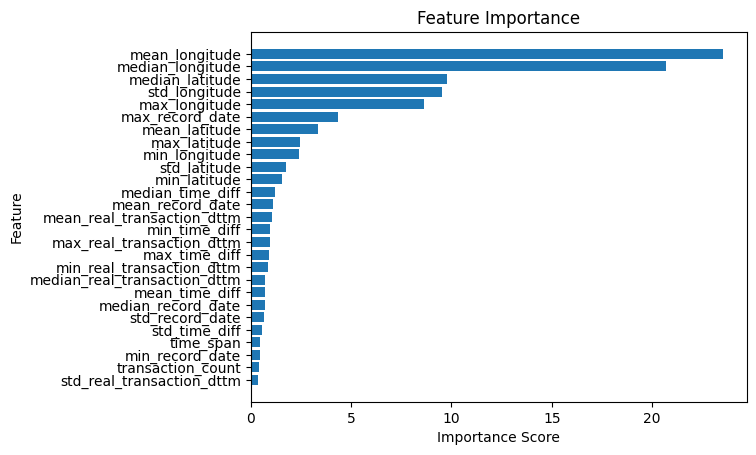

In [12]:
# Get the feature importance scores
feat_importance = pd.DataFrame({'feature': feature_columns, 'importance': model.feature_importances_})
feat_importance = feat_importance.sort_values(by='importance', ascending=True)

# Plot the feature importance scores
plt.barh(feat_importance['feature'], feat_importance['importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


# LSTM model

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Hyperparameters
input_size = 5
output_size = 2
hidden_size = 512
num_layers = 1
num_epochs = 50
batch_size = 512
maxlen = 300  # maximum sequence length
learning_rate = 0.01


# Custom collate function to handle variable-length sequences
def collate_fn(batch):
    batch.sort(key=lambda x: len(x['inputs']), reverse=True)
    sequences = [x['inputs'] for x in batch]
    targets = [x['target'] for x in batch]
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded_sequences = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    targets = torch.stack(targets)
    return padded_sequences, lengths, targets


class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, feature_columns, target_columns, feature_scaler, target_scaler, maxlen=20):
        self.feature_columns = feature_columns
        self.target_columns = target_columns
        self.maxlen = maxlen
        
        df = df.copy()

        # normalize data
        df[feature_columns] = feature_scaler.transform(df[feature_columns])
        df[target_columns] = target_scaler.transform(df[target_columns])

        # create a list of tuples, where each tuple contains the merchant_id and a group of transactions
        self.data = [(merchant_id, transactions) for merchant_id, transactions in df.groupby('merchant_id')]
        self.merchant_ids = [d[0] for d in self.data]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # get the merchant_id and the transactions for the given index
        merchant_id, transactions = self.data[idx]

        # sample transactions
        transactions = transactions.sample(n=min(self.maxlen, len(transactions)), replace=False)

        inputs = torch.tensor(transactions[self.feature_columns].values).float()
        target = torch.tensor(transactions[self.target_columns].iloc[0].values).float()

        # return a dictionary with the processed transactions and the merchant_id
        return {'inputs': inputs, 'merchant_id': merchant_id, 'target': target}

    def subset(self, merchant_ids):
        # Note: remove this method, unused
        merchant_ids_set = set(merchant_ids)
        indices = [i for i, (merchant_id) in enumerate(self.merchant_ids) if merchant_id in merchant_ids_set]
        return torch.utils.data.Subset(self, indices)


# Create a copy of training data
df = train_data.copy()

# Convert time to float format
df['real_transaction_dttm'] = df['real_transaction_dttm'].dt.hour / 24 + df['real_transaction_dttm'].dt.minute / (24 * 60) + df['real_transaction_dttm'].dt.second / (24 * 60 * 60)
df['record_date'] = df['record_date'].dt.hour / 24 + df['record_date'].dt.minute / (24 * 60) + df['record_date'].dt.second / (24 * 60 * 60)
df['time_diff'] = df['real_transaction_dttm'] - df['record_date']

feature_columns = ['latitude_trans', 'longitude_trans','real_transaction_dttm','record_date', 'time_diff']
target_columns = ['latitude_merch', 'longitude_merch']

# Create scalers to normalize data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

feature_scaler.fit(df[feature_columns])
target_scaler.fit(df[target_columns])

dataset = Dataset(df, feature_columns, target_columns, feature_scaler, target_scaler, maxlen=maxlen)

# Split into train and validation
torch.random.manual_seed(0)
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])


# Create DataLoader with custom collate function
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


def average_sequence(x, lengths):
    lengths = lengths.to(device)
    mask = torch.arange(x.size(1)).expand(x.size(0), x.size(1)).to(device) < lengths.unsqueeze(1)

    # Convert mask to float and calculate sum along length dimension
    mask = mask.type(torch.float32).to(device)
    masked_sum = torch.sum(x * mask.unsqueeze(2), dim=1)

    # Calculate average by dividing the masked sum by the sequence lengths
    avg_x = masked_sum / lengths.unsqueeze(1).type(torch.float32)

    return avg_x

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Pack the padded sequence
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=True)
        packed_out, _ = self.lstm(packed_x, (h0, c0))
        
        # Unpack the packed sequence
        out, _ = pad_packed_sequence(packed_out, batch_first=True)

        # Get the average embeddings
        out = average_sequence(out, lengths)
        
        out = self.fc(out)
        return out


# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = lambda x, y: ((x-y)**2).sum().pow(0.5).mean()  # RMSE
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train_epoch():
    model.train()
    loss = 0
    n = 0
    for i, (inputs, lengths, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        bsize = inputs.size(0)
        
        outputs = model(inputs, lengths)
        batch_loss = criterion(outputs, targets)

        optimizer.zero_grad()
        batch_loss.backward()
        
        # clip gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        optimizer.step()
        print(f'batch_loss:', batch_loss.item())
        
        loss += batch_loss.item() * bsize
        n += bsize
    
    loss /= n
    return loss


@torch.no_grad()
def evaluate(dataloader):
    model.eval()
    loss = 0
    error = 0
    n = 0
    for i, (inputs, lengths, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        bsize = inputs.size(0)
        
        outputs = model(inputs, lengths)
        batch_loss = criterion(outputs, targets)
        
        targets = target_scaler.inverse_transform(targets.cpu().numpy())
        outputs = target_scaler.inverse_transform(outputs.cpu().numpy())
        batch_error = np.sqrt(((outputs - targets)**2).sum(axis=1)).mean()
        
        loss += batch_loss.item() * bsize
        error += batch_error.item() * bsize
        n += bsize
    
    loss /= n
    error /= n
    return loss, error


# Training loop with model checkpointing
best_rmse = float('inf')
for epoch in range(num_epochs):
    train_loss = train_epoch()
    validation_loss, validation_error = evaluate(validation_loader)
    if validation_error < best_rmse:
        # Save the best model checkpoint based on validation RMSE
        torch.save(model.state_dict(), 'best_model.pth')
        best_rmse = validation_error 
    print(f'Epoch [{epoch+1}/{num_epochs}], train_loss: {train_loss:.4f}, \
          validation_loss: {validation_loss:.4f},  \
          validation_rmse: {validation_error:.4f}')
        
# Load and Evaluate the Best Model from Checkpoint File    
model.load_state_dict(torch.load('best_model.pth'))

validation_loss, validation_error = evaluate(validation_loader)
print('===============> Finished training.')
print(f'Best model validation_rmse: {validation_error:.4f}')



batch_loss: 43.27899932861328
batch_loss: 32.48501968383789
batch_loss: 101.13383483886719
batch_loss: 76.41575622558594
batch_loss: 56.43623733520508
batch_loss: 48.282752990722656
batch_loss: 35.95115280151367
batch_loss: 41.88825988769531
batch_loss: 36.630306243896484
batch_loss: 36.913238525390625
batch_loss: 13.479192733764648
Epoch [1/50], train_loss: 47.5359,           validation_loss: 34.3668,            validation_rmse: 6.5713
batch_loss: 36.869144439697266
batch_loss: 37.70198440551758
batch_loss: 38.454891204833984
batch_loss: 38.4627799987793
batch_loss: 41.79742431640625
batch_loss: 37.80924987792969
batch_loss: 39.125267028808594
batch_loss: 38.51750564575195
batch_loss: 32.24033737182617
batch_loss: 36.692901611328125
batch_loss: 15.734366416931152
Epoch [2/50], train_loss: 35.7642,           validation_loss: 34.2460,            validation_rmse: 7.2558
batch_loss: 39.21759033203125
batch_loss: 35.62322998046875
batch_loss: 32.14494323730469
batch_loss: 36.23774337768555